# 任务四：机器学习算法实践（开放式题型，三选一）

（3）房租价格预测，至少用到一种机器学习算法。

In [21]:
import os,sys
SRC_DIR = os.path.join(os.path.abspath('.'), 'data')
print(SRC_DIR)

c:\Users\Administrator\WPSDrive\205034987\WPS云盘\07 绛亽新学习\01 电子商务\05 20级大四上学期\商务智能实验\notebook\data


In [22]:
%pip install statsmodels

Looking in indexes: https://mirrors.tencent.com/pypi/simple
Note: you may need to restart the kernel to use updated packages.


In [23]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import preprocessing as SLP
import numpy as np
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from sklearn import linear_model
import seaborn as sns
import statsmodels.api as sm
from scipy import stats
plt.rcParams["font.sans-serif"] = ["SimHei"] # 中文显示
plt.rcParams["axes.unicode_minus"] = False # 负号显示

#读取数据
data = pd.read_csv(os.path.join(SRC_DIR, '_listings.csv'),
                   usecols=['latitude', 'longitude', 'room_type', 'reviews_per_month', 'number_of_reviews', 'availability_365',
                            'minimum_nights', 'calculated_host_listings_count', 'price', 'neighbourhood'], encoding='utf-8')
# 通过此前的数据预处理，已知99%的价格不高于5000
data2 = data.drop(data[data['price']>5000].index) # 过滤极值，缩小区间凸显图例

# 设置价值
data = data.replace('Entire home/apt', 9)
data = data.replace('Private room', 6)
data = data.replace('Shared room', 3)


# 查看数据集大小和特征组成
print('Shape:',data.shape)
print('Columns:',data.columns.tolist())
data.head()

Shape: (28452, 10)
Columns: ['neighbourhood', 'latitude', 'longitude', 'room_type', 'price', 'minimum_nights', 'number_of_reviews', 'reviews_per_month', 'calculated_host_listings_count', 'availability_365']


,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
0,朝阳区,39.89503,116.45163,9,792,1,89,0.85,9,341
1,密云县,40.68434,117.17231,6,1201,1,2,0.10,4,0
2,东城区,39.93213,116.42200,9,389,3,259,2.70,1,93
3,东城区,39.93357,116.43577,9,376,1,26,0.28,5,290
4,朝阳区,39.93668,116.43798,9,537,1,37,0.40,5,352


### 创建测试集

In [24]:
data.info() #获得特征的数据类型

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28452 entries, 0 to 28451
Data columns (total 10 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   neighbourhood                   28452 non-null  object 
 1   latitude                        28452 non-null  float64
 2   longitude                       28452 non-null  float64
 3   room_type                       28452 non-null  int64  
 4   price                           28452 non-null  int64  
 5   minimum_nights                  28452 non-null  int64  
 6   number_of_reviews               28452 non-null  int64  
 7   reviews_per_month               17294 non-null  float64
 8   calculated_host_listings_count  28452 non-null  int64  
 9   availability_365                28452 non-null  int64  
dtypes: float64(3), int64(6), object(1)
memory usage: 2.2+ MB


In [25]:
data['neighbourhood'].value_counts() #对城市区数据进行统计

neighbourhood
朝阳区     10810
东城区      3346
海淀区      3197
丰台区      1758
西城区      1701
通州区      1290
昌平区      1034
密云县       935
顺义区       920
怀柔区       833
大兴区       823
延庆县       718
房山区       579
石景山区      213
门头沟区      152
平谷区       143
Name: count, dtype: int64

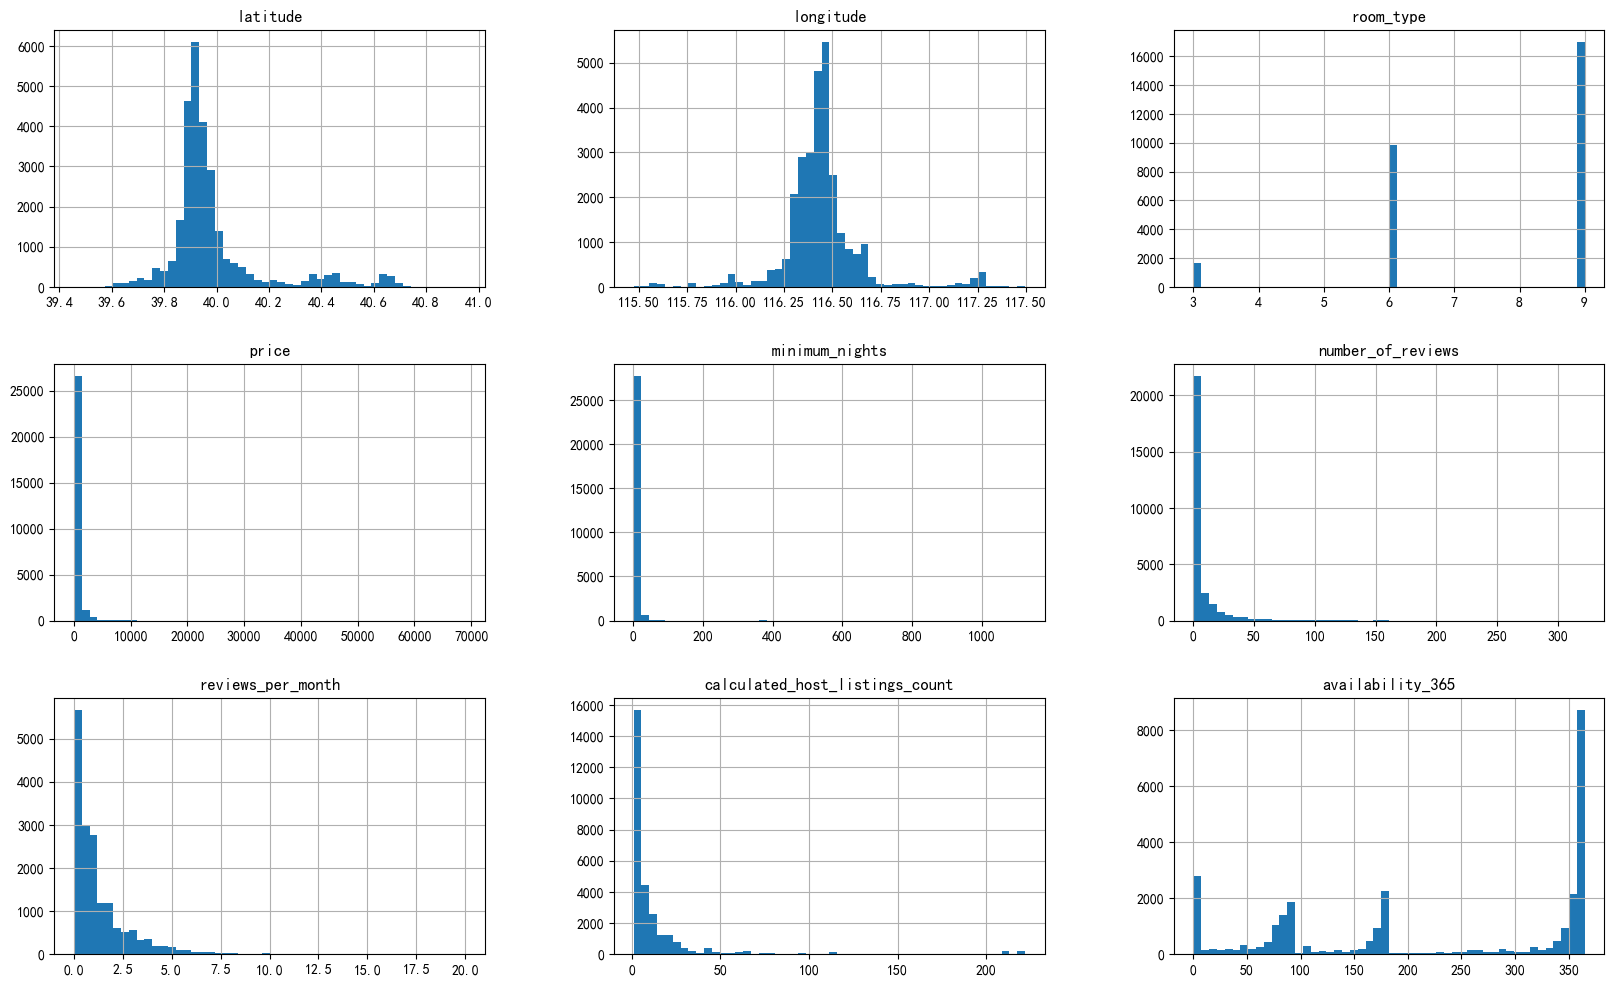

In [26]:
data.hist(bins=50,figsize=(20,12))
plt.show()

上图可以看出：
* 柱状图多为长尾的，是有偏的，对于某些机器学习算法，这会使得检测规律变得困难，后面会尝试变换处理这些属性，使其成为正态分布，比如Log变换。
* 这些属性有不同的量度，需要特征缩放

***
创建收入的类别属性，以产生离散的分类，然后将所有大于5的类别归于分类5

In [27]:
data['income_cat']=np.ceil(data['availability_365']/30)
data['income_cat'].head()

0    12.0
1     0.0
2     4.0
3    10.0
4    12.0
Name: income_cat, dtype: float64

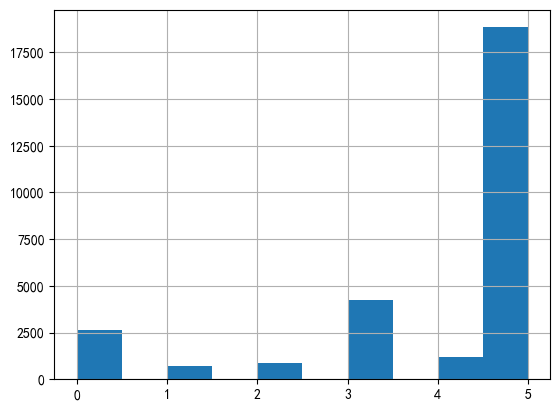

In [28]:
data['income_cat'].where(data['income_cat']<5,5.0,inplace=True)
data['income_cat'].hist()
plt.show()

In [29]:
from sklearn.model_selection import StratifiedShuffleSplit as SSS
split=SSS(n_splits=1,test_size=0.2,random_state=42)
for train_index,test_index in split.split(data,data['income_cat']):
    strat_train_set=data.loc[train_index]
    strat_test_set=data.loc[test_index]
# 查看分层抽样后测试集的分布情况
print(strat_test_set['income_cat'].value_counts()/len(strat_test_set))
print('len:',len(strat_test_set))
print('-'*150)
# 查看原始数据集的分布情况
print(data['income_cat'].value_counts()/len(data))
print('len:',len(data))

income_cat
5.0    0.661922
3.0    0.148831
0.0    0.092075
4.0    0.041996
2.0    0.030750
1.0    0.024425
Name: count, dtype: float64
len: 5691
------------------------------------------------------------------------------------------------------------------------------------------------------
income_cat
5.0    0.661852
3.0    0.148812
0.0    0.092155
4.0    0.041965
2.0    0.030824
1.0    0.024392
Name: count, dtype: float64
len: 28452


> 分层采样是将人群分成均匀的子分组，从每个分组去取合适数量的实例，保证测试集对总体具有代表性。如果随机采样的话，会产生严重的偏差。<br>
**可以看出：测试集和原始数据集的分布状况几乎一致。**

现在删除 income_cat ，使数据回到最初的状态。

In [30]:
for set_ in (strat_train_set,strat_test_set):
    set_.drop('income_cat',axis=1,inplace=True)
print("OK")

OK


### 数据可视化

<Axes: xlabel='availability_365', ylabel='Count'>

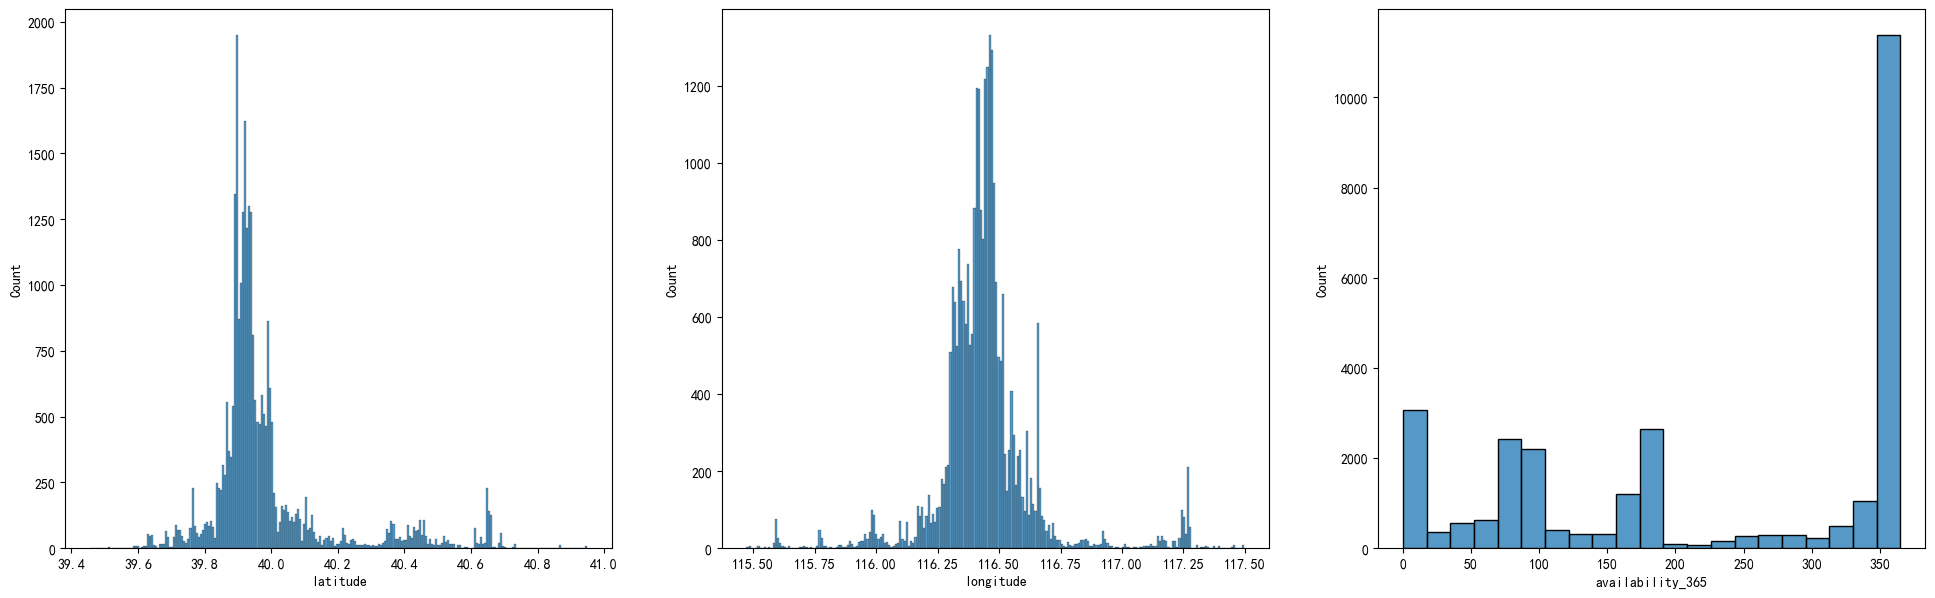

In [31]:
fig, axes = plt.subplots(1,3, figsize=(24,7))
sns.histplot(data['latitude'], ax=axes[0])
sns.histplot(data['longitude'], ax=axes[1])
sns.histplot(data['availability_365'], ax=axes[2])

<Axes: xlabel='latitude', ylabel='longitude'>

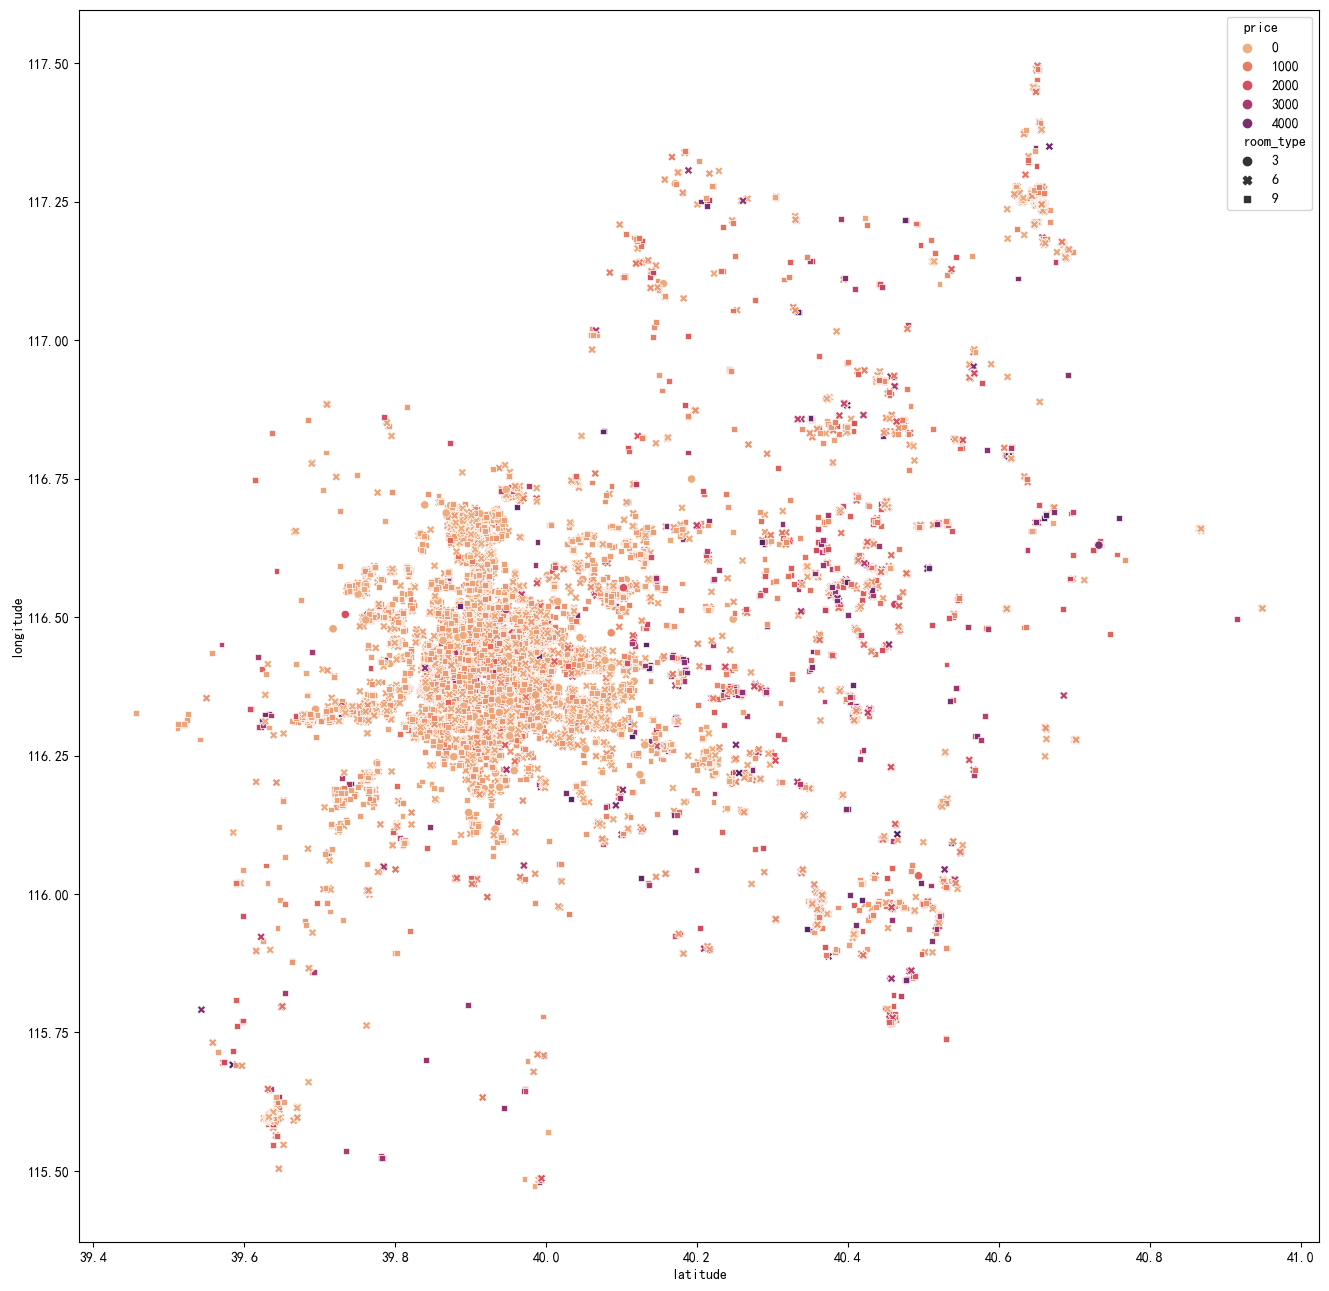

In [32]:
plt.figure(figsize=(16, 16))
pp = sns.color_palette("flare", as_cmap=True)
sns.scatterplot(x=data['latitude'], y=data['longitude'], hue=data2['price'], style=data['room_type'], palette=pp)

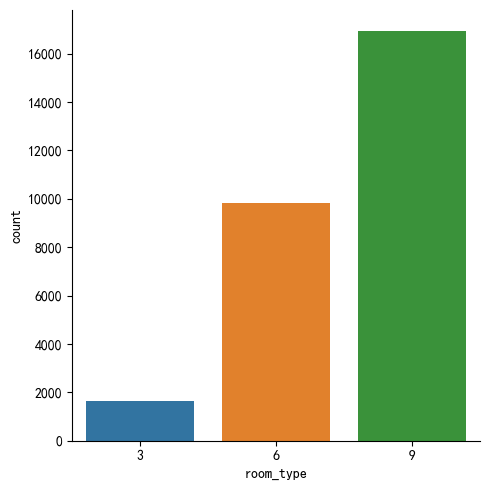

In [33]:
sns.catplot(x='room_type',  kind='count', data=data)
fig = plt.gca()

room_type转化为数字，sklearn为该任务提供了一个转换器LabelEncoder：

In [34]:
encoder=SLP.LabelEncoder()
data_cat=data['neighbourhood']
data_cat_encoded=encoder.fit_transform(data_cat)
print(data_cat_encoded[:250])
#根据编码后的类别，反向推导出编码前对应的原始标签
print(encoder.inverse_transform([0,1,2]))

[ 9  3  0  0  9  0  9  9  9  0  0  9  9  0  9  9  0  9 12  9 10  9  0 10
  9  0  0  0  3  0 15  0  0  0  9 10  9  0  0  0  0  9  9  9  9  0  0  0
  9  7  9  9  0  9  9  9 12  0  9  9 10  0  0  9  9  9  0 10 10 10  0  0
  0  9  9 10  9 10  9  9  9  9  0  6  9  9 15 15  9  9  6  9 10  8 15  9
 10  9  0  9  9 13  9  9  9 12  9  9  6 10  9  9  9  9 10  1  9  9 10  9
  9  9 12  9  9  1 12  9  9  9  1  9  1  9  9  9  9  9  9  9  9  9  9  9
  9  9  9  9  9  9  1  8  9  9  0  9  9  9 12 12 12  6 12  9  9  9 10  9
  9  1  1  8  9  9 12  0  9 12  9  0  0  0  1 12  0  9 10 13  2  0 12  9
 10 15 12 15  9 10 10  0 15  9  9  9  9 12 10  6  0  9 13  9  9  9  9  9
  0  9  9  9 10  9  9  9  9  9  9 10  9  9 10  9  1 13  1  9  6 12  7  9
  8 15  9 10  2  0  0 15  0 10]
['东城区' '丰台区' '大兴区']


***
这样的做法并不符合预期，这并不是我们的让机器学习的本意，只是想让机器区分它们，因此接下来进行独热编码。

独热编码（哑变量 dummy variable）是因为大部分算法是基于向量空间中的度量来进行计算的，为了使非偏序关系的变量取值不具有偏序性，并且到圆点是等距的。使用one-hot编码，将离散特征的取值扩展到了欧式空间，离散特征的某个取值就对应欧式空间的某个点。将离散型特征使用one-hot编码，会让特征之间的距离计算更加合理。

In [35]:
encoder=SLP.LabelBinarizer()
data_cat_hot_nb=encoder.fit_transform(data['neighbourhood'])
data_cat_hot_rt=encoder.fit_transform(data['room_type'])
print(data_cat_hot_nb)
print('-'*150)
print(data_cat_hot_rt)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 1 0 ... 0 0 0]]
------------------------------------------------------------------------------------------------------------------------------------------------------
[[0 0 1]
 [0 1 0]
 [0 0 1]
 ...
 [0 0 1]
 [0 1 0]
 [0 0 1]]


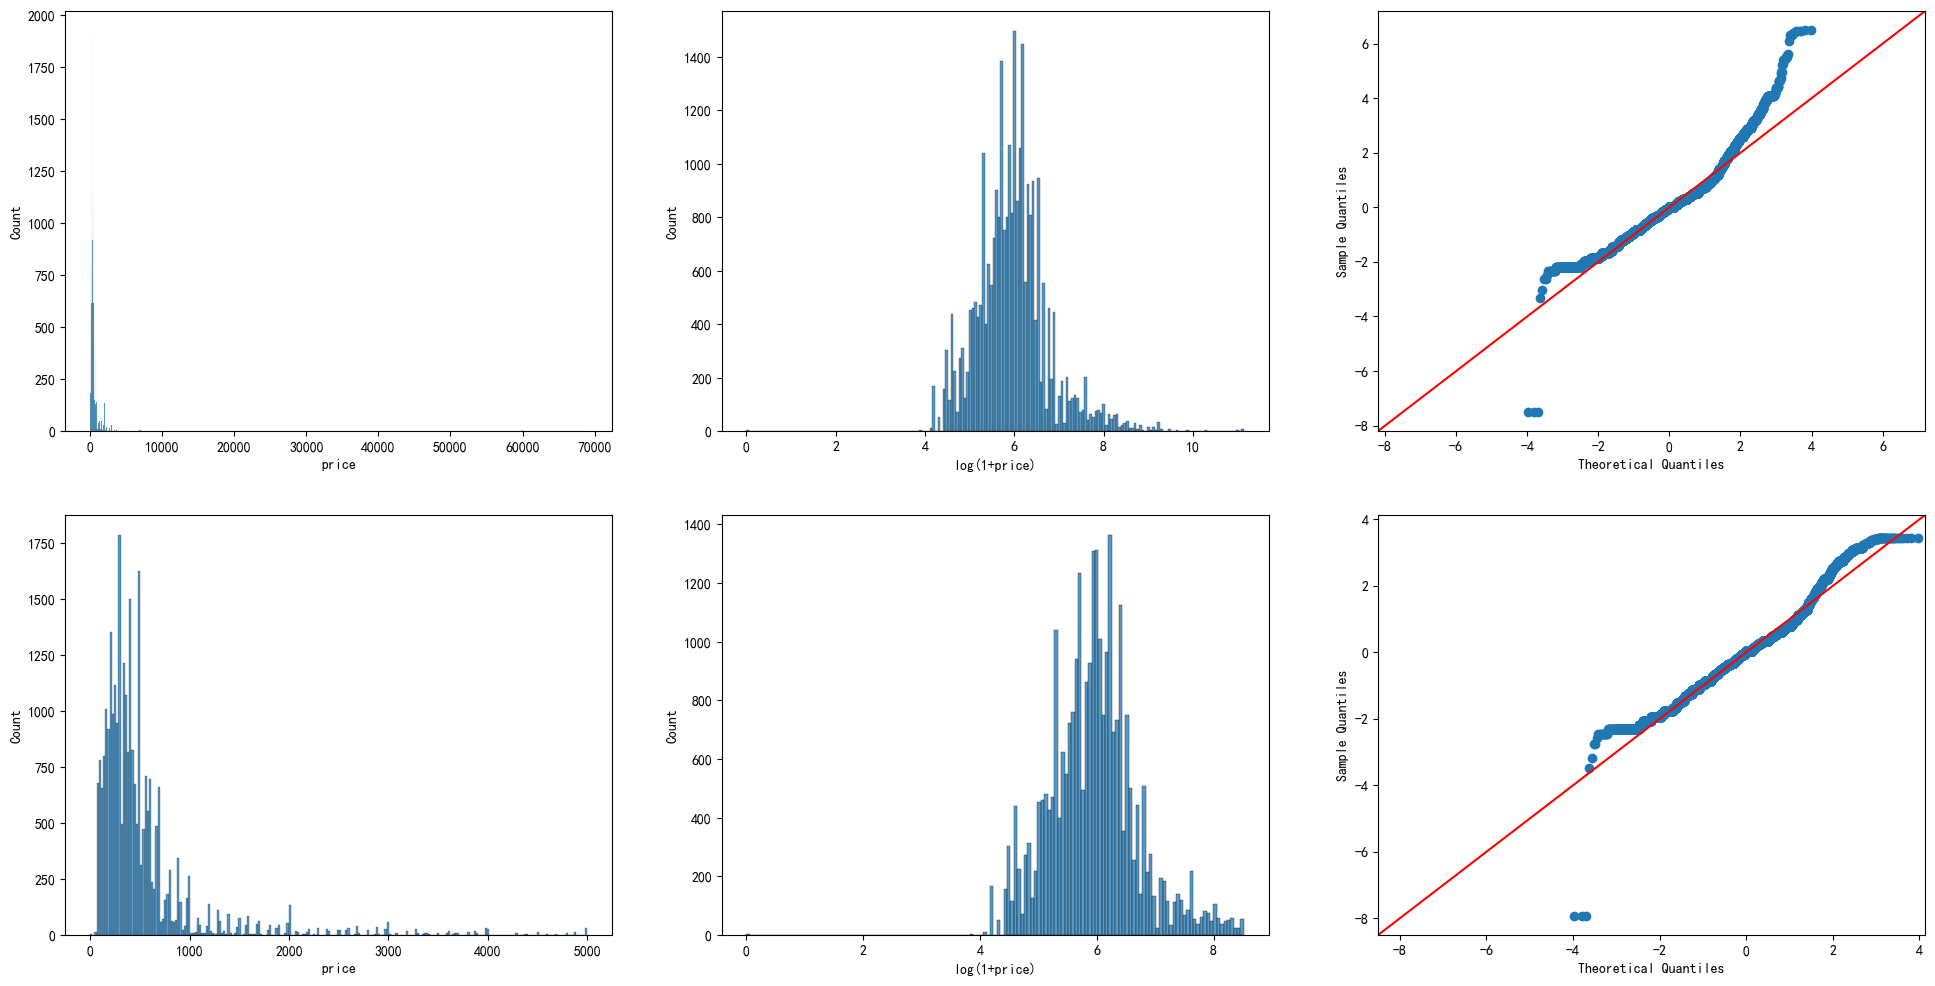

In [36]:
# 全价格区间
fig, axes = plt.subplots(2,3, figsize=(24,12))
sns.histplot(data['price'], ax=axes[0,0])
sns.histplot(np.log1p(data['price']), ax=axes[0,1])
axes[0,1].set_xlabel('log(1+price)')
sm.qqplot(np.log1p(data['price'])#数据
          ,stats.norm#分布方式
          , fit=True#大概就是个自动进行fit的设置：如果fit为true，则dist的参数使用dist.fit自动拟合
          , line='45'#线的设置
          , ax=axes[0,2]);

# 放大价格区间
sns.histplot(data2['price'], ax=axes[1,0])
sns.histplot(np.log1p(data2['price']), ax=axes[1,1])
axes[1,1].set_xlabel('log(1+price)')
sm.qqplot(np.log1p(data2['price'])#数据
          ,stats.norm#分布方式
          , fit=True#大概就是个自动进行fit的设置：如果fit为true，则dist的参数使用dist.fit自动拟合
          , line='45'#线的设置
          , ax=axes[1,2]);

In [37]:
import numpy as np
import pandas as pd

# 假设 data 是你的 DataFrame
data_float = data.apply(pd.to_numeric, errors='coerce')
data_float

,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,income_cat
0,NaN,39.89503,116.45163,9,792,1,89,0.85,9,341,5.0
1,NaN,40.68434,117.17231,6,1201,1,2,0.10,4,0,0.0
2,NaN,39.93213,116.42200,9,389,3,259,2.70,1,93,4.0
3,NaN,39.93357,116.43577,9,376,1,26,0.28,5,290,5.0
4,NaN,39.93668,116.43798,9,537,1,37,0.40,5,352,5.0
...,...,...,...,...,...,...,...,...,...,...,...
28447,NaN,39.98671,116.47394,9,396,1,0,NaN,1,89,3.0
28448,NaN,39.92560,116.44735,9,1302,3,0,NaN,6,4,1.0
28449,NaN,39.89733,116.50473,9,329,1,0,NaN,1,363,5.0
28450,NaN,39.95988,116.45187,6,188,1,0,NaN,6,84,3.0


In [50]:
num_df = data.select_dtypes(include='number')
num_df

,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,income_cat
0,0,39.89503,116.45163,0,6.675823,1,89,0.85,9,5.0,5.0
1,0,40.68434,117.17231,0,7.091742,1,2,0.10,4,0.0,0.0
2,1,39.93213,116.42200,0,5.966147,3,259,2.70,1,4.0,4.0
3,1,39.93357,116.43577,0,5.932245,1,26,0.28,5,5.0,5.0
4,0,39.93668,116.43798,0,6.287859,1,37,0.40,5,5.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...
28447,0,39.98671,116.47394,0,5.983936,1,0,NaN,1,3.0,3.0
28448,0,39.92560,116.44735,0,7.172425,3,0,NaN,6,1.0,1.0
28449,0,39.89733,116.50473,0,5.799093,1,0,NaN,1,5.0,5.0
28450,0,39.95988,116.45187,0,5.241747,1,0,NaN,6,3.0,3.0


### 特征之间的相关性分析

皮尔森相关系数和热力图

对相关性的分析采用皮尔斯相关系数，皮尔森相关系数的大小，可以反映出两个变量之间线性相关的程度。

借助seaborn中的热力图(heatmap)进行可视化。

<Axes: >

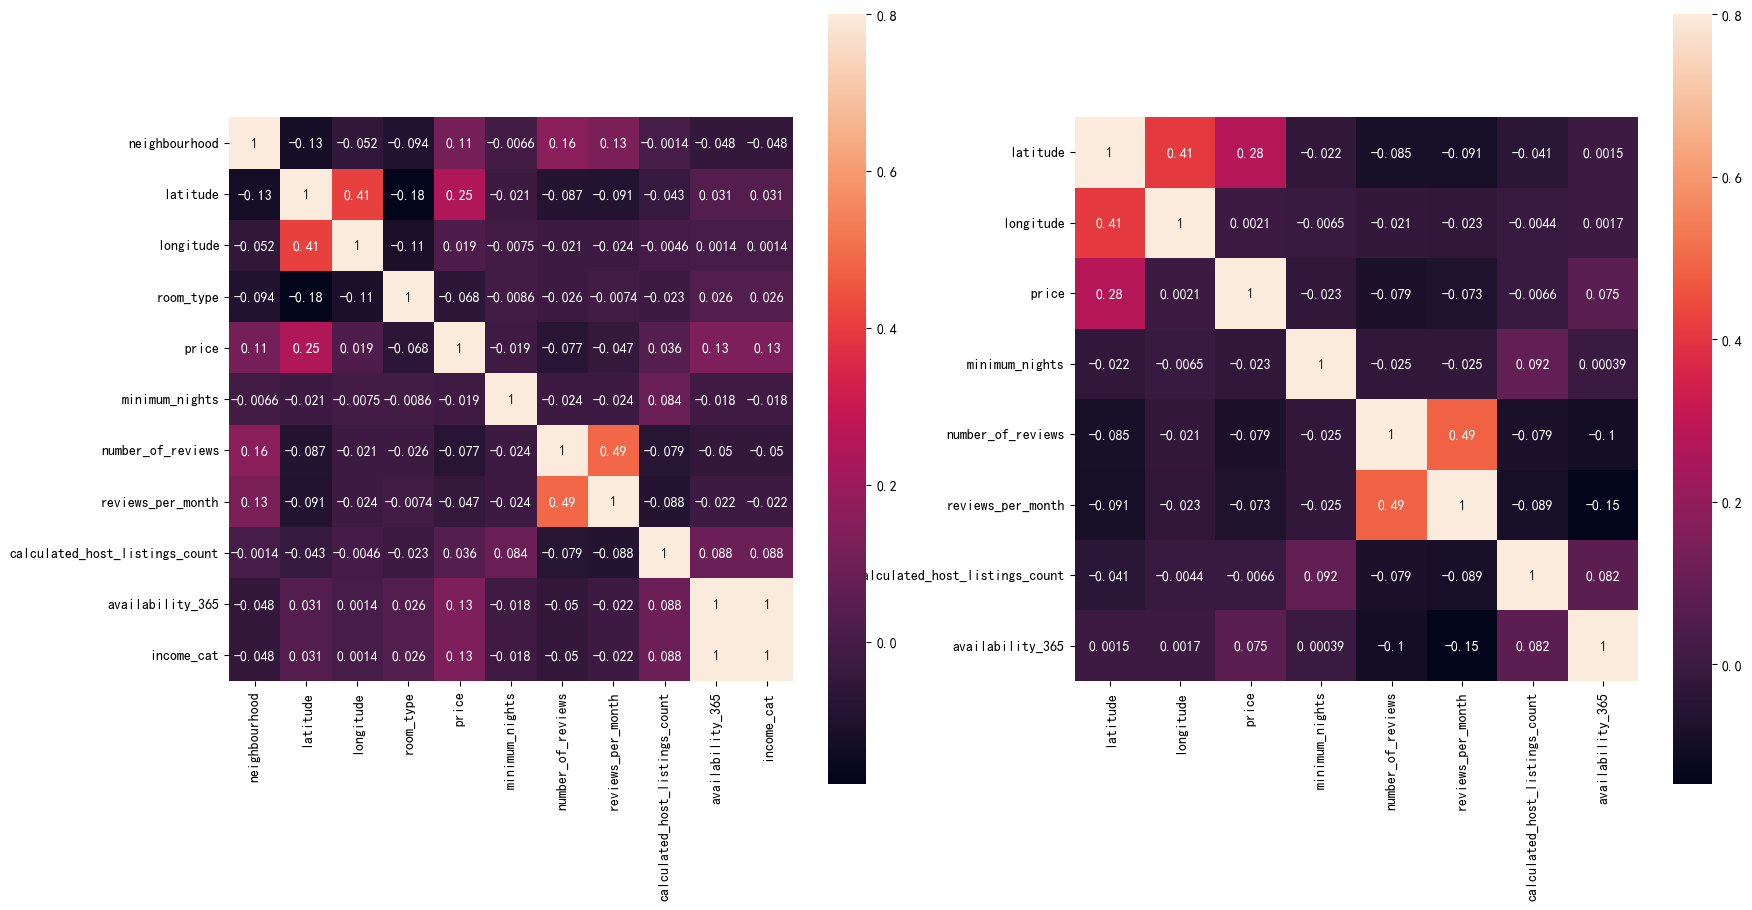

In [59]:

fig, axes = plt.subplots(1,2, figsize=(20,10))
sns.heatmap(data.select_dtypes(include='number').corr(), vmax=0.8, square=True,annot=True,ax=axes[0]) # 全价格区间
sns.heatmap(data2.select_dtypes(include='number').corr(), vmax=0.8, square=True,annot=True,ax=axes[1]) # 放大价格区间

结果显示，对房价影响因素最大的，其实是经纬度，其次是房间的类型。

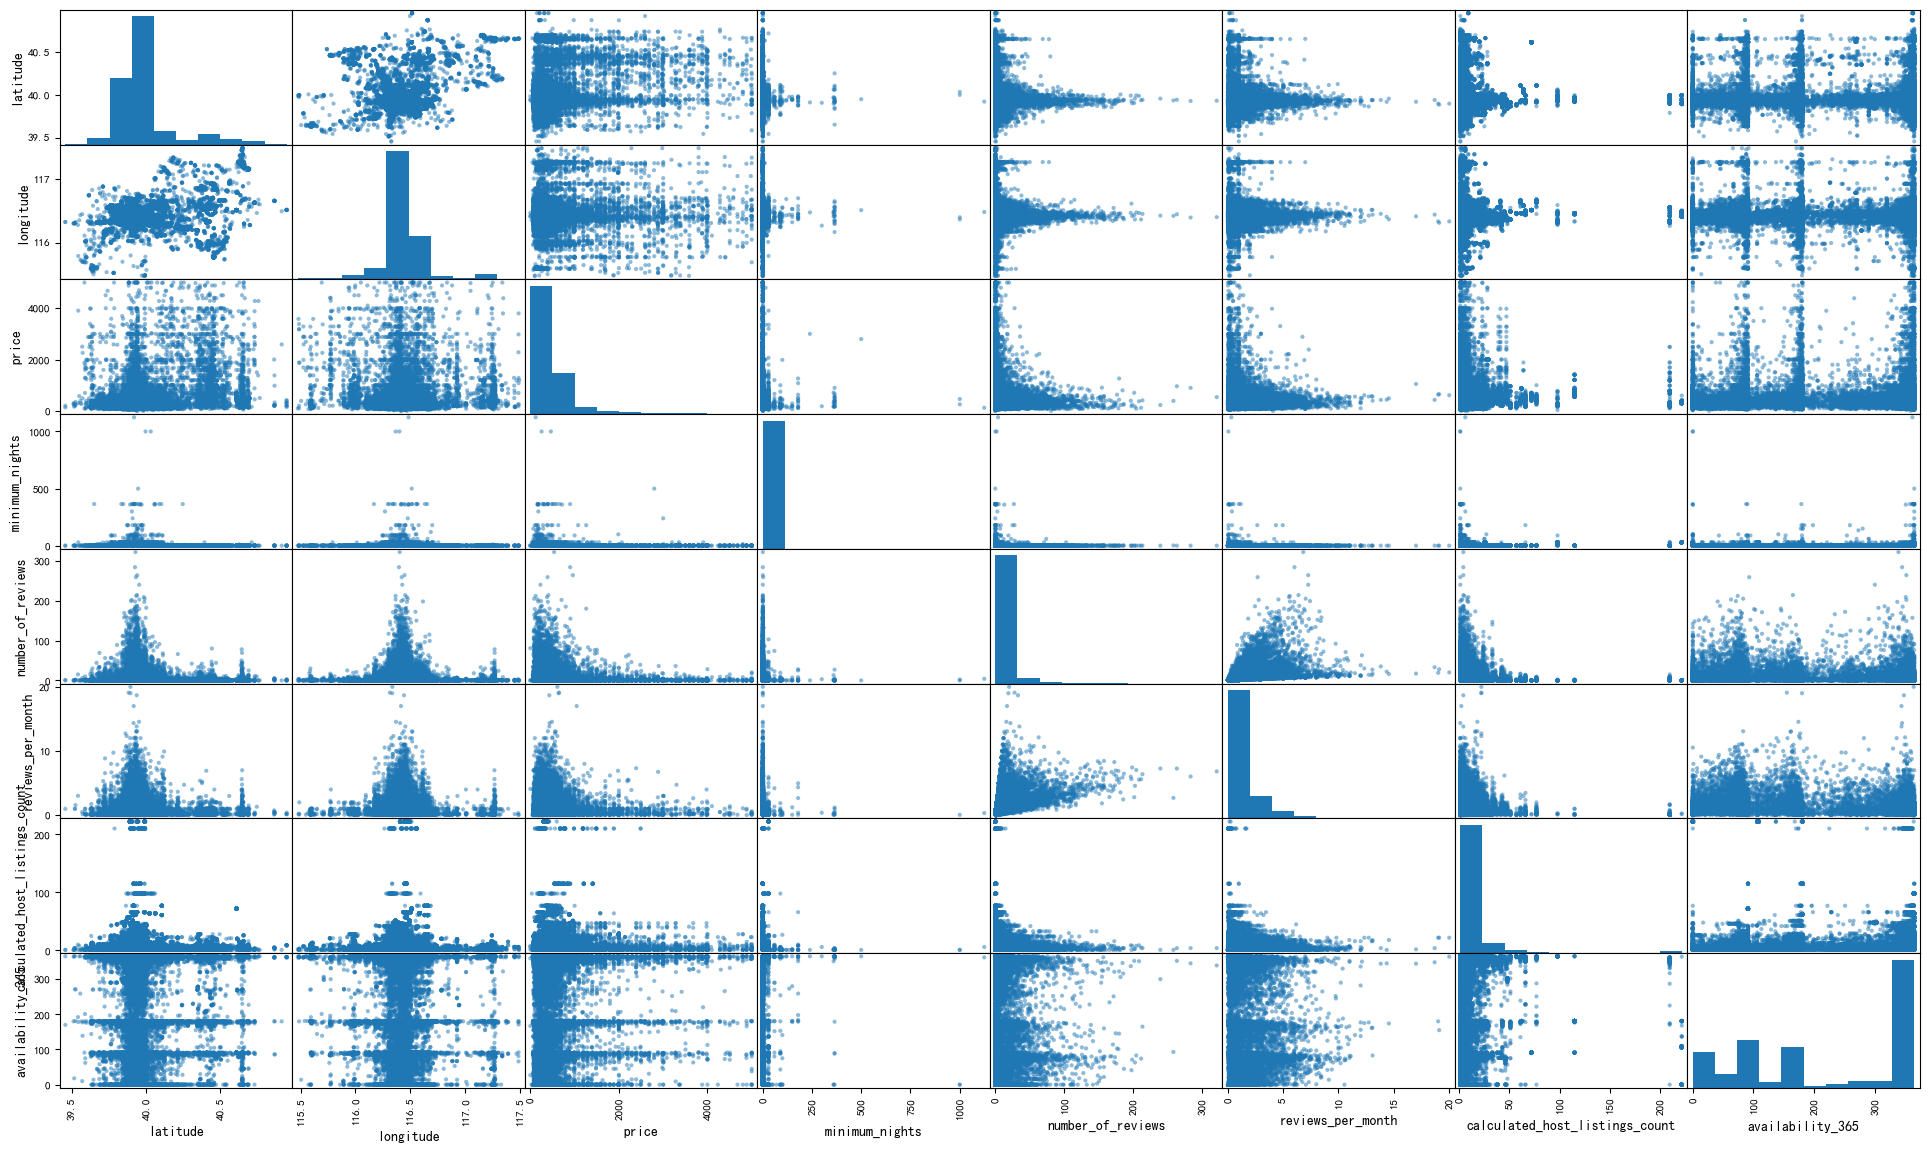

In [39]:
from pandas.plotting import scatter_matrix
scatter_matrix(data2,figsize=(24,14))
plt.show()

Text(0, 0.5, 'latitude')

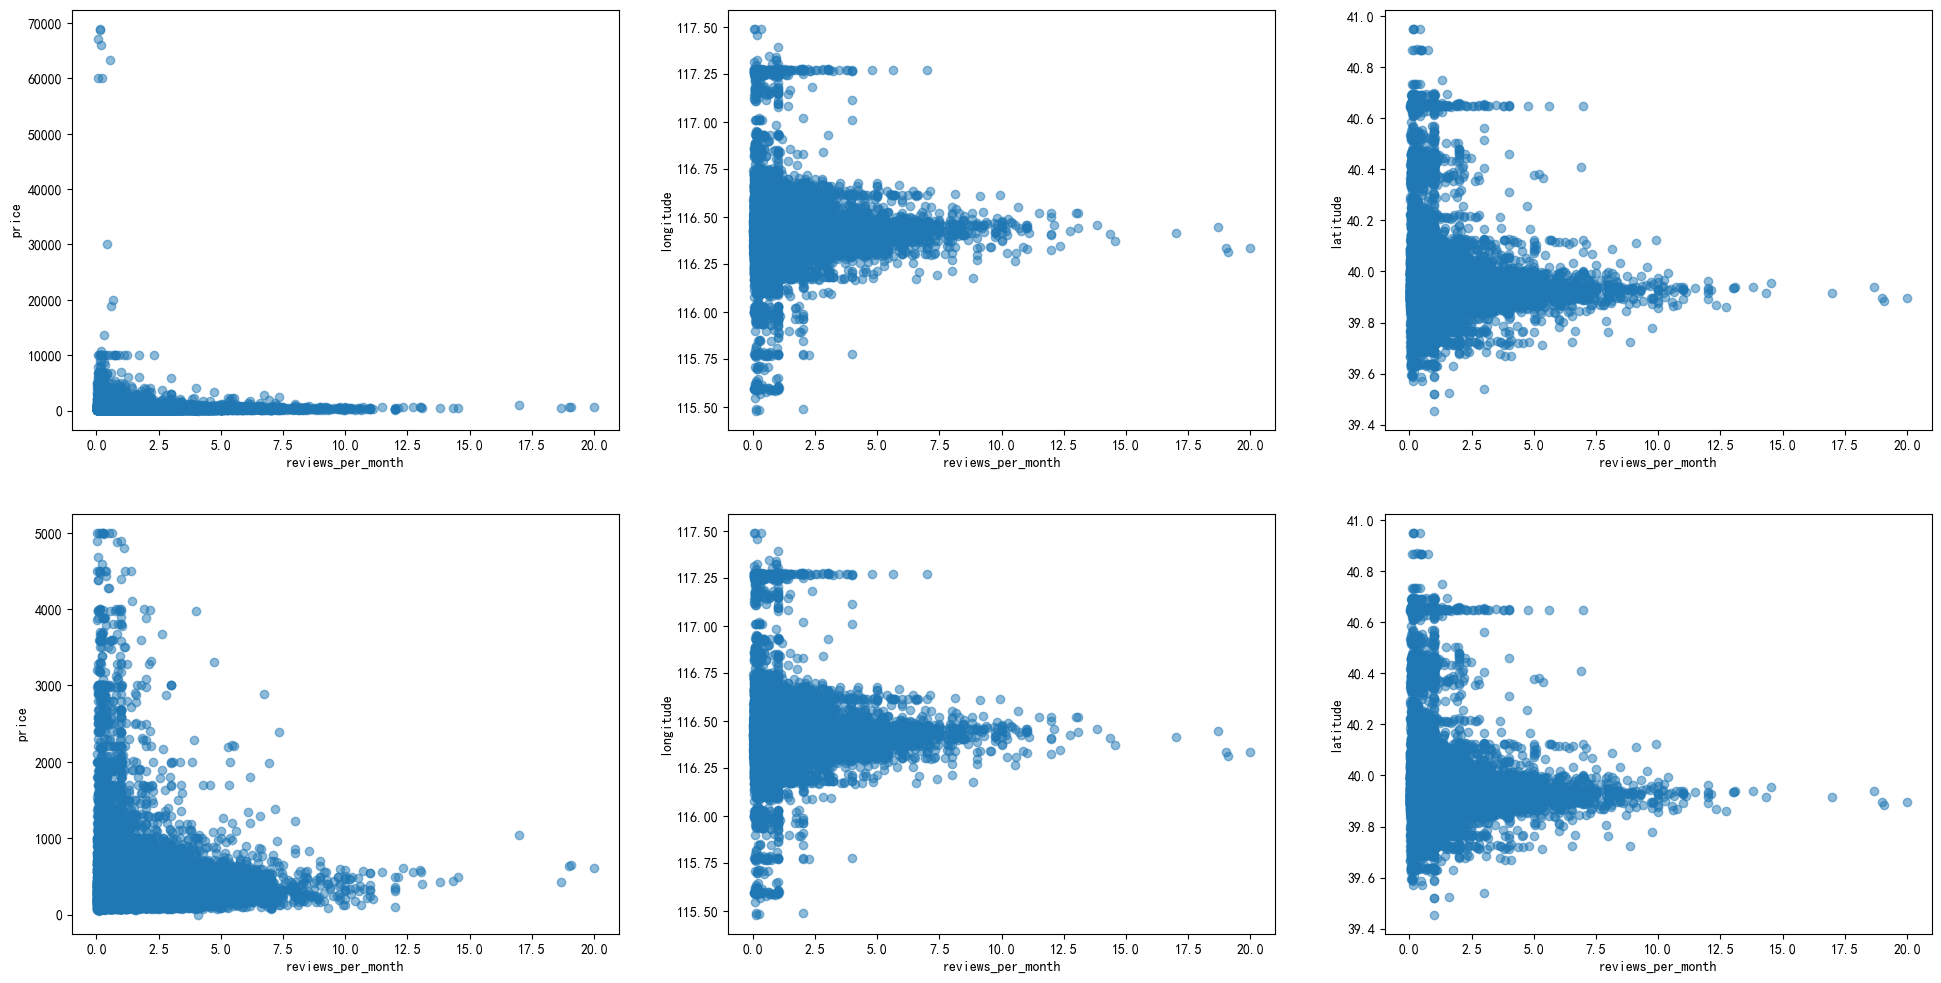

In [40]:
'''
在房价500一下的房源相对拥有更多的评论，更受用户欢迎。同时，经度越靠近116.40，维度越靠近39.9附近的房源，拥有更多的评论。
'''

fig,ax=plt.subplots(2,3,figsize=(24,12))

# 全价格区间
ax[0,0].scatter(x=data['reviews_per_month'],y=data['price'],alpha=.5)
ax[0,0].set_xlabel(xlabel='reviews_per_month')
ax[0,0].set_ylabel(ylabel='price')
ax[0,1].scatter(x=data['reviews_per_month'],y=data['longitude'],alpha=.5)
ax[0,1].set_xlabel(xlabel='reviews_per_month')
ax[0,1].set_ylabel(ylabel='longitude')
ax[0,2].scatter(x=data['reviews_per_month'],y=data['latitude'],alpha=.5)
ax[0,2].set_xlabel(xlabel='reviews_per_month')
ax[0,2].set_ylabel(ylabel='latitude')

# 放大价格区间
ax[1,0].scatter(x=data2['reviews_per_month'],y=data2['price'],alpha=.5)
ax[1,0].set_xlabel(xlabel='reviews_per_month')
ax[1,0].set_ylabel(ylabel='price')
ax[1,1].scatter(x=data2['reviews_per_month'],y=data2['longitude'],alpha=.5)
ax[1,1].set_xlabel(xlabel='reviews_per_month')
ax[1,1].set_ylabel(ylabel='longitude')
ax[1,2].scatter(x=data2['reviews_per_month'],y=data2['latitude'],alpha=.5)
ax[1,2].set_xlabel(xlabel='reviews_per_month')
ax[1,2].set_ylabel(ylabel='latitude')

最有希望用来预测房价的属性是reviews_per_month，因此将这张图放大：

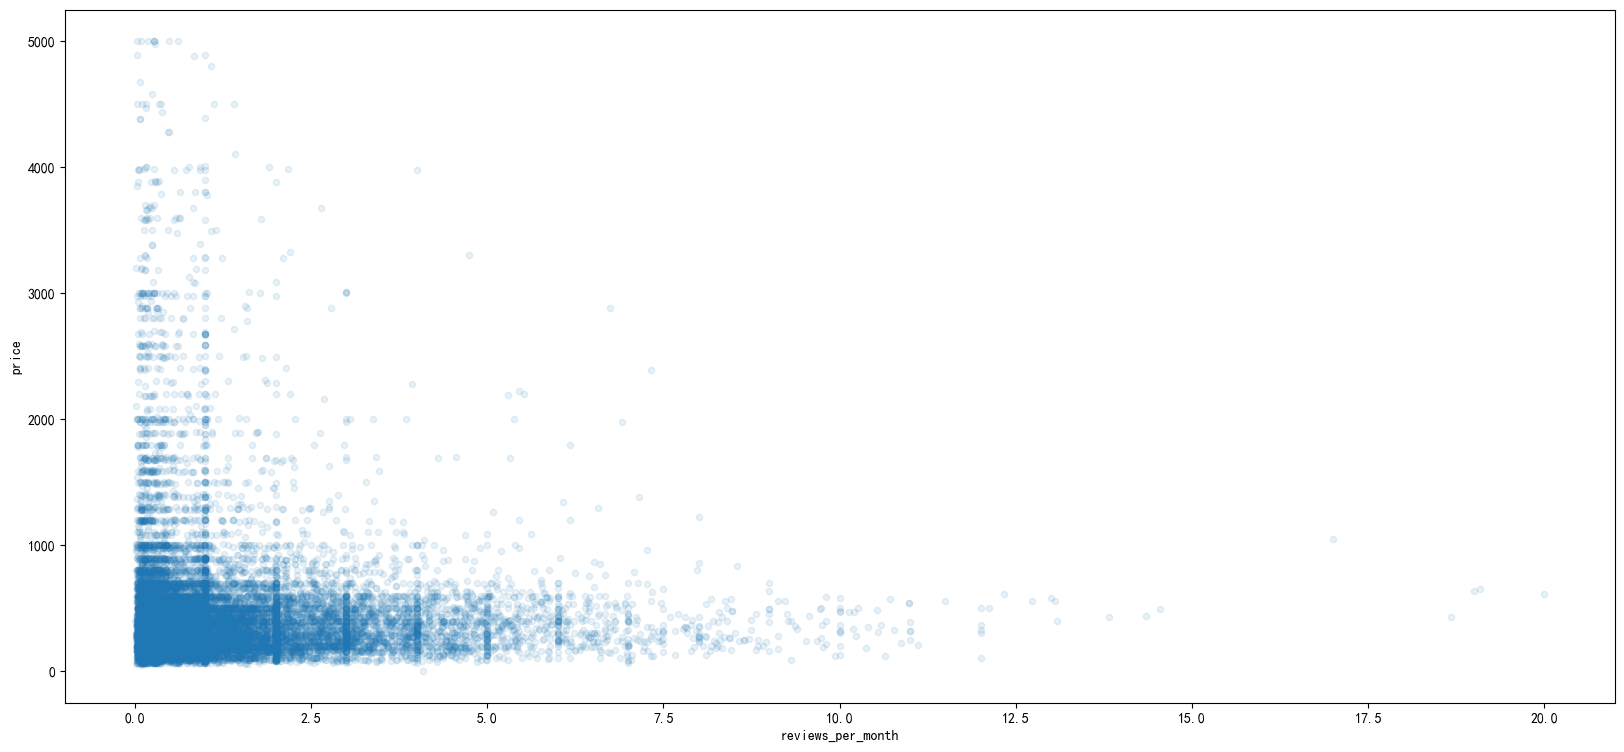

In [41]:
data2.plot(kind='scatter',x='reviews_per_month',y='price',alpha=0.1,figsize=(20,9))
plt.show()

### 选择并训练模型

$Price = \theta_0 + \theta_1·room\_type + \theta_2·reviews\_per\_month + \theta_3·neighbourhood + \theta_4·availability\_365$

In [42]:
encoder=SLP.LabelBinarizer()
#将房间价格数据的分布转换成近似的高斯分布。
data['price'] = np.log1p(data['price'])
data['neighbourhood'] = encoder.fit_transform(data['neighbourhood'])
data['room_type'] = encoder.fit_transform(data['room_type'])
data['availability_365'] = np.ceil(data['availability_365']/30)
data['availability_365'].where(data['availability_365']<5,5.0,inplace=True)
Y = data['price']
X = data[['room_type','reviews_per_month','neighbourhood','availability_365']]
X.head()

,room_type,reviews_per_month,neighbourhood,availability_365
0,0,0.85,0,5.0
1,0,0.10,0,0.0
2,0,2.70,1,4.0
3,0,0.28,1,5.0
4,0,0.40,0,5.0


划分训练集和测试集,75%的样本数据被作为训练集，25%的样本被作为测试集：

In [43]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state=1)
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

(21339, 4)
(21339,)
(7113, 4)
(7113,)


In [44]:
from sklearn.linear_model import LinearRegression
linreg = LinearRegression()
linreg.fit(X_train,Y_train)
# 查看模型系数拟合结果
print(linreg.intercept_)
print(linreg.coef_)

ValueError: Input X contains NaN.
LinearRegression does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

### 用测试集评估系统

#### 模型评估

回归模型的性能评估不同于分类模型，虽然都是对照真实值进行评估，但由于回归模型的预测结果和真实值都是连续的，所以不能求 Precision、Recall 和 F1 值等评价指标。<br>
常用的回归模型评价指标如下表：

|    方法名称   | 最优值 |            sklearn 函数          |
|:-------------:|:------:|:--------------------------------:|
|  平均绝对误差 |   0.0  |    metrics.mean_absolute_error   |
|    均方误差   |   0.0  |    metrics.mean_squared_error    |
|  中值绝对误差 |   0.0  |   metrics.median_absolute_error  |
|  可解释方差值 |   1.0  | metrics.explained_variance_score |
|   $R^2$ 方差值  |   1.0  |         metrics.r2_score         |

平均绝对误差、均方误差（MSE）和中值绝对误差的值越靠近0，模型性能越好。可解释方差值和R方值则越靠近1，模型性能越好。

In [ ]:
# 模型拟合测试集
Y_PRED = linreg.predict(X_test)
from sklearn import metrics
# 计算 MSE
print("MSE:",metrics.mean_squared_error(Y_test,Y_PRED))

MSE: 0.3410761543031755


MSE约等于0.341，说明模型性能不错。

#### 交叉验证

利用train_test_split函数可以很快地将数据集分为训练集和测试集。在训练集上通过调整参数设置使估计器的性能达到了最佳状态，但在测试集上可能会出现过拟合的情况。<br>
为了解决此类问题，还应该准备另一部分被称为验证集的数据集，模型训练完成以后在验证集上对模型进行评估。当验证集上的评估实验比较成功时，再在测试集上进行最后的评估。<br>
然而，将原始数据分为3个数据集合，将大大减少可用于模型学习的样本数量，并且得到的结果依赖于集合对（训练，验证）的随机选择。为了解决该问题，提出了教程验证（CV）的方法。<br>
***

In [ ]:
Y = data['price']
X = data[['room_type','reviews_per_month','neighbourhood','availability_365']]

from sklearn.model_selection import cross_val_predict
predicted = cross_val_predict(linreg,X,Y,cv=10)
print("MSE:",metrics.mean_squared_error(Y,predicted))

MSE: 0.35625184385588127


此处，通过交叉验证来持续优化模型，用10折交叉验证（每次用一个折进行评估，用其余九个折进行训练），即cross_val_predict中的cv参数为10。但是MSE并没有变小。

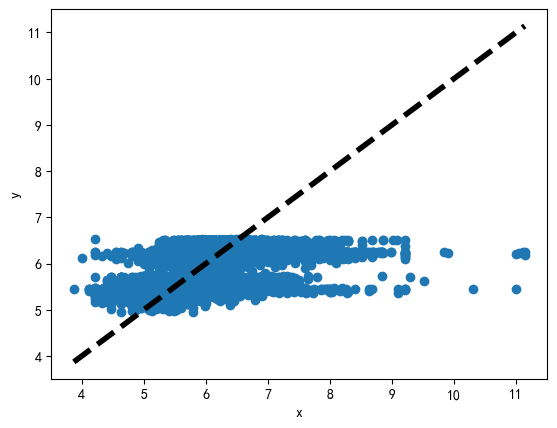

In [ ]:
fig,ax = plt.subplots()
ax.scatter(Y,predicted)
ax.plot([Y.min(),Y.max()],[Y.min(),Y.max()],'k--',lw=4)
ax.set_xlabel('x')
ax.set_ylabel('y')
plt.show()

#
\- The End -